https://www.kaggle.com/datasets/kartik2112/fraud-detection?select=fraudTrain.csv

index - Unique Identifier for each row

trans_date_trans_time - Transaction DateTime

cc_num - Credit Card Number of Customer

merchant - Merchant Name

category - Category of Merchant

amt - Amount of Transaction

first - First Name of Credit Card Holder

last - Last Name of Credit Card Holder

gender - Gender of Credit Card Holder

street - Street Address of Credit Card Holder

city - City of Credit Card Holder

state - State of Credit Card Holder

zip - Zip of Credit Card Holder

lat - Latitude Location of Credit Card Holder

long - Longitude Location of Credit Card Holder

city_pop - Credit Card Holder's City Population

job - Job of Credit Card Holder

dob - Date of Birth of Credit Card Holder

trans_num - Transaction Number

unix_time - UNIX Time of transaction

merch_lat - Latitude Location of Merchant

merch_long - Longitude Location of Merchant

is_fraud - Fraud Flag <--- Target Class

In [ ]:
import joblib

import pandas as pd
import numpy as np
from scipy import stats
import optuna

from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (average_precision_score, precision_recall_curve, 
                             PrecisionRecallDisplay, RocCurveDisplay,
                             confusion_matrix, roc_curve)
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

pd.set_option('display.max_columns', None)
random_state = 33

In [2]:
df = pd.read_csv(r'./data/fraudTrain.csv', index_col=0, parse_dates=['trans_date_trans_time'])
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   trans_date_trans_time  1296675 non-null  datetime64[ns]
 1   cc_num                 1296675 non-null  int64         
 2   merchant               1296675 non-null  object        
 3   category               1296675 non-null  object        
 4   amt                    1296675 non-null  float64       
 5   first                  1296675 non-null  object        
 6   last                   1296675 non-null  object        
 7   gender                 1296675 non-null  object        
 8   street                 1296675 non-null  object        
 9   city                   1296675 non-null  object        
 10  state                  1296675 non-null  object        
 11  zip                    1296675 non-null  int64         
 12  lat                    1296675 no

In [4]:
df.cc_num.nunique()

983

In [5]:
df \
    .groupby(['first', 'last', 'dob', 'lat', 'long'], as_index=False) \
    .cc_num \
    .nunique() \
    .cc_num \
    .max()
# У каждого пользователя ровно по 1 карте. По сути cc_num - это id пользователя

np.int64(1)

In [6]:
df.select_dtypes(include=object).describe()

,merchant,category,first,last,gender,street,city,state,job,dob,trans_num
count,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675,1296675
unique,693,14,352,481,2,983,894,51,494,968,1296675
top,fraud_Kilback LLC,gas_transport,Christopher,Smith,F,864 Reynolds Plains,Birmingham,TX,Film/video editor,1977-03-23,0b242abb623afc578575680df30655b9
freq,4403,131659,26669,28794,709863,3123,5617,94876,9779,5636,1


In [7]:
df.cc_num.nunique()

983

In [8]:
df.is_fraud.value_counts()

is_fraud
0    1289169
1       7506
Name: count, dtype: int64

Text(0.5, 1.0, 'Доли фродовых операций от всех операций на пол')

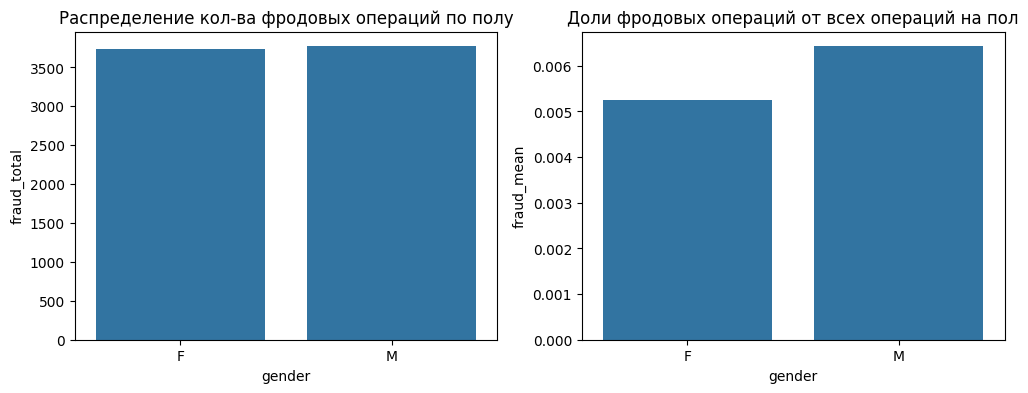

In [9]:
tmp = df \
    .groupby('gender', as_index=False) \
    .agg(
        fraud_total=('is_fraud', pd.Series.sum),
        fraud_mean=('is_fraud', pd.Series.mean)
    )

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.barplot(data=tmp, x='gender', y='fraud_total', ax=ax[0])
ax[0].set_title('Распределение кол-ва фродовых операций по полу')
sns.barplot(data=tmp, x='gender', y='fraud_mean', ax=ax[1])
ax[1].set_title('Доли фродовых операций от всех операций на пол')

H0: Распредение фродовых операций не зависит от пола.
H1: ... зависит.

Построим таблицу сопряжнности и воспользуемся критерием $\chi^2$.

In [10]:
stats.chi2_contingency(pd.crosstab(df.gender, df.is_fraud))

Chi2ContingencyResult(statistic=np.float64(75.51456622055794), pvalue=np.float64(3.627211385830374e-18), dof=1, expected_freq=array([[705753.85030713,   4109.14969287],
       [583415.14969287,   3396.85030713]]))

p-value < 0.05. Значит распределение фродовых операций зависит от пола пользователя. Можно сказать, что доля фродовых операций среди мужчин статистически значимо выше.

Text(0.5, 1.0, 'Доли фродовых операций от всех операций на категорию')

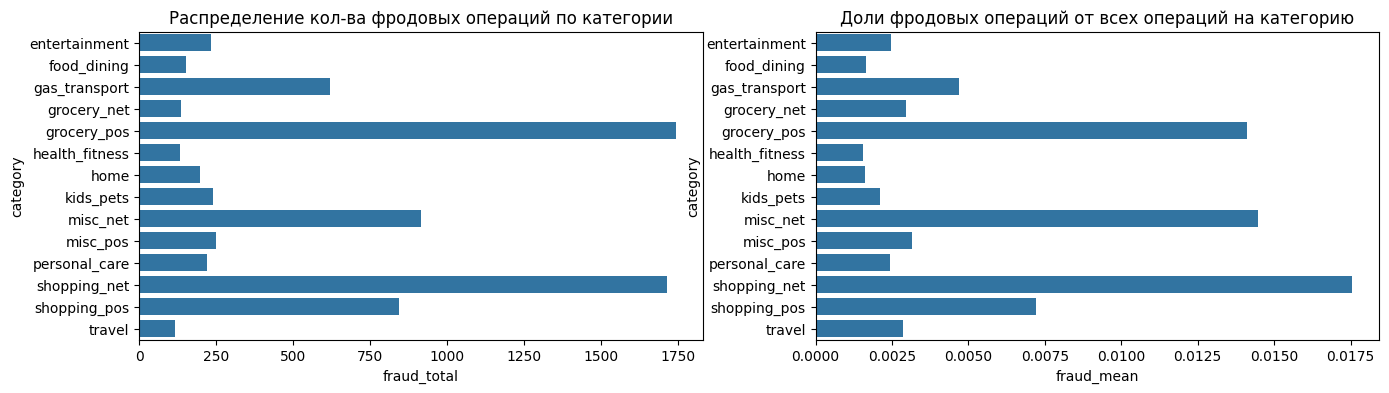

In [11]:
tmp = df \
    .groupby('category', as_index=False) \
    .agg(
        fraud_total=('is_fraud', pd.Series.sum),
        fraud_mean=('is_fraud', pd.Series.mean)
    )

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sns.barplot(data=tmp, x='fraud_total', y='category', ax=ax[0])
ax[0].set_title('Распределение кол-ва фродовых операций по категории')
sns.barplot(data=tmp, x='fraud_mean', y='category', ax=ax[1])
ax[1].set_title('Доли фродовых операций от всех операций на категорию')

Text(0.5, 1.0, 'Доли фродовых операций от всех операций на штат (топ 10)')

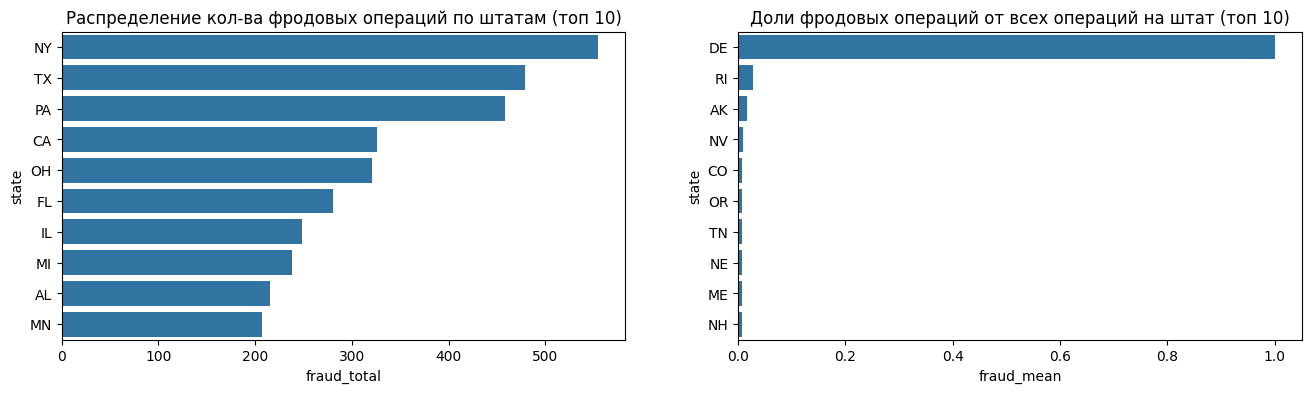

In [12]:
tmp = df \
    .groupby('state', as_index=False) \
    .agg(
        fraud_total=('is_fraud', pd.Series.sum),
        fraud_mean=('is_fraud', pd.Series.mean)
    )

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sns.barplot(data=tmp.sort_values('fraud_total', ascending=False)[:10], x='fraud_total', y='state', ax=ax[0])
ax[0].set_title('Распределение кол-ва фродовых операций по штатам (топ 10)')
sns.barplot(data=tmp.sort_values('fraud_mean', ascending=False)[:10], x='fraud_mean', y='state', ax=ax[1])
ax[1].set_title('Доли фродовых операций от всех операций на штат (топ 10)')

In [13]:
df[df.state == 'DE'].cc_num.nunique()

1

Видно, что все операции в штате Делавэр произведены одним человеком и все они мошеннические.


In [14]:
df['trans_date'] = df.trans_date_trans_time.dt.date
df['weekday'] = df.trans_date_trans_time.dt.strftime("%A")
df['month'] = df.trans_date_trans_time.dt.month_name()

In [15]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_date,weekday,month
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,2019-01-01,Tuesday,January
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,2019-01-01,Tuesday,January
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,2019-01-01,Tuesday,January
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,2019-01-01,Tuesday,January
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,2019-01-01,Tuesday,January


In [16]:
fig = make_subplots(
    rows=2, 
    cols=1, 
    subplot_titles=(
        'Кол-во мошеннических операций по дням', 
        'Доля мошеннических операций по дням'
    )
)

tmp = df \
    .groupby(['trans_date'], as_index=False) \
    .agg(
        fraud_total=('is_fraud', pd.Series.count),
            fraud_mean=('is_fraud', pd.Series.mean),
    )

fig.add_trace(
    go.Scatter(x=tmp.trans_date, y=tmp.fraud_total),
    row=1, col=1, 
)

fig.add_trace(
    go.Scatter(x=tmp.trans_date, y=tmp.fraud_mean),
    row=2, col=1, 
)

fig.update_layout(height=800)
fig.show()

Text(0.5, 1.0, 'Доли фродовых операций от всех операций на день недели')

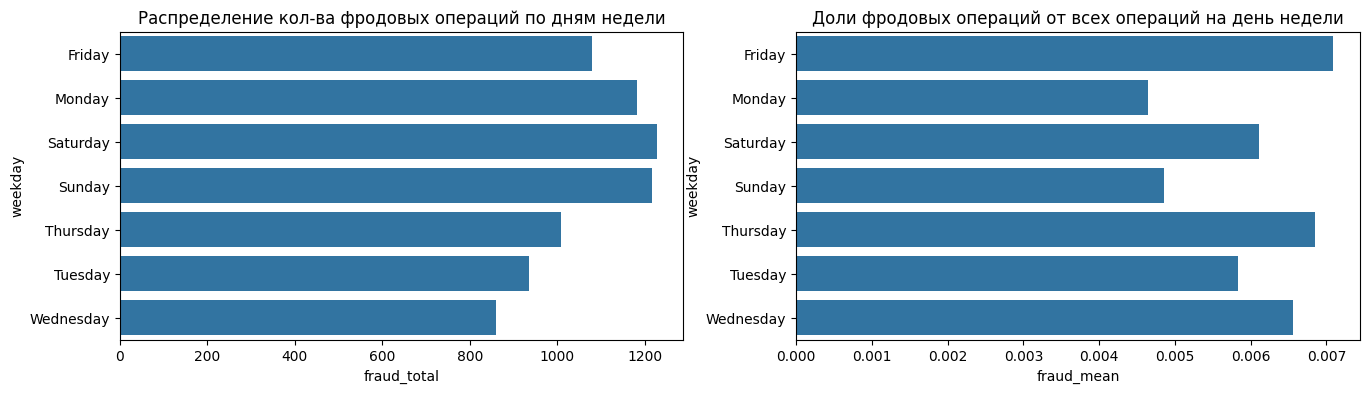

In [17]:
tmp = df \
    .groupby('weekday', as_index=False) \
    .agg(
        fraud_total=('is_fraud', pd.Series.sum),
        fraud_mean=('is_fraud', pd.Series.mean)
    )

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sns.barplot(data=tmp, x='fraud_total', y='weekday', ax=ax[0])
ax[0].set_title('Распределение кол-ва фродовых операций по дням недели')
sns.barplot(data=tmp, x='fraud_mean', y='weekday', ax=ax[1])
ax[1].set_title('Доли фродовых операций от всех операций на день недели')

Text(0.5, 1.0, 'Доли фродовых операций от всех операций на день недели')

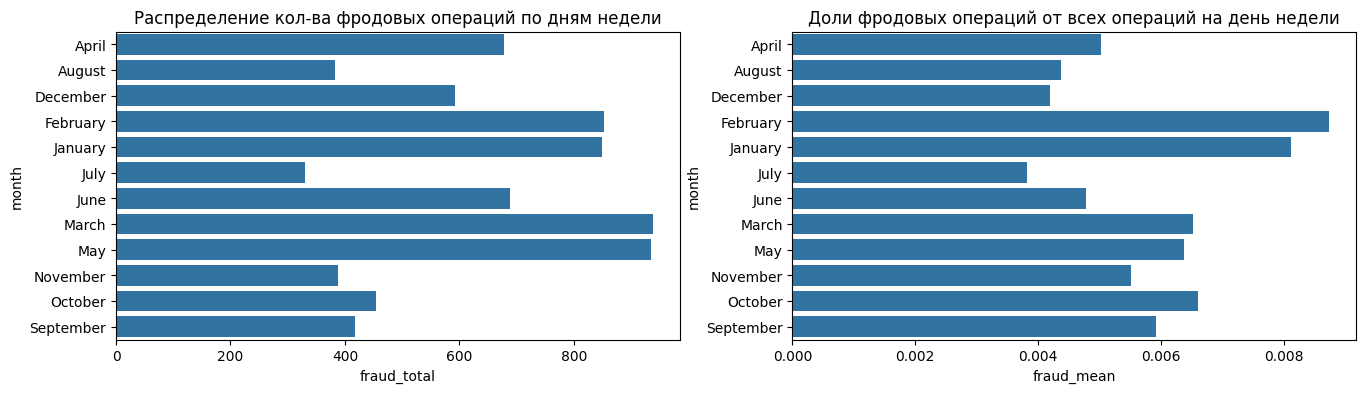

In [ ]:
tmp = df \
    .groupby('month', as_index=False) \
    .agg(
        fraud_total=('is_fraud', pd.Series.sum),
        fraud_mean=('is_fraud', pd.Series.mean)
    )

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
sns.barplot(data=tmp, x='fraud_total', y='month', ax=ax[0])
ax[0].set_title('Распределение кол-ва фродовых операций по месяцам')
sns.barplot(data=tmp, x='fraud_mean', y='month', ax=ax[1])
ax[1].set_title('Доли фродовых операций от всех операций на месяц')

In [19]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_date,weekday,month
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,2019-01-01,Tuesday,January
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,2019-01-01,Tuesday,January
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,2019-01-01,Tuesday,January
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,2019-01-01,Tuesday,January
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,2019-01-01,Tuesday,January


C:\Users\Shull\AppData\Local\Temp\ipykernel_12960\2720261648.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



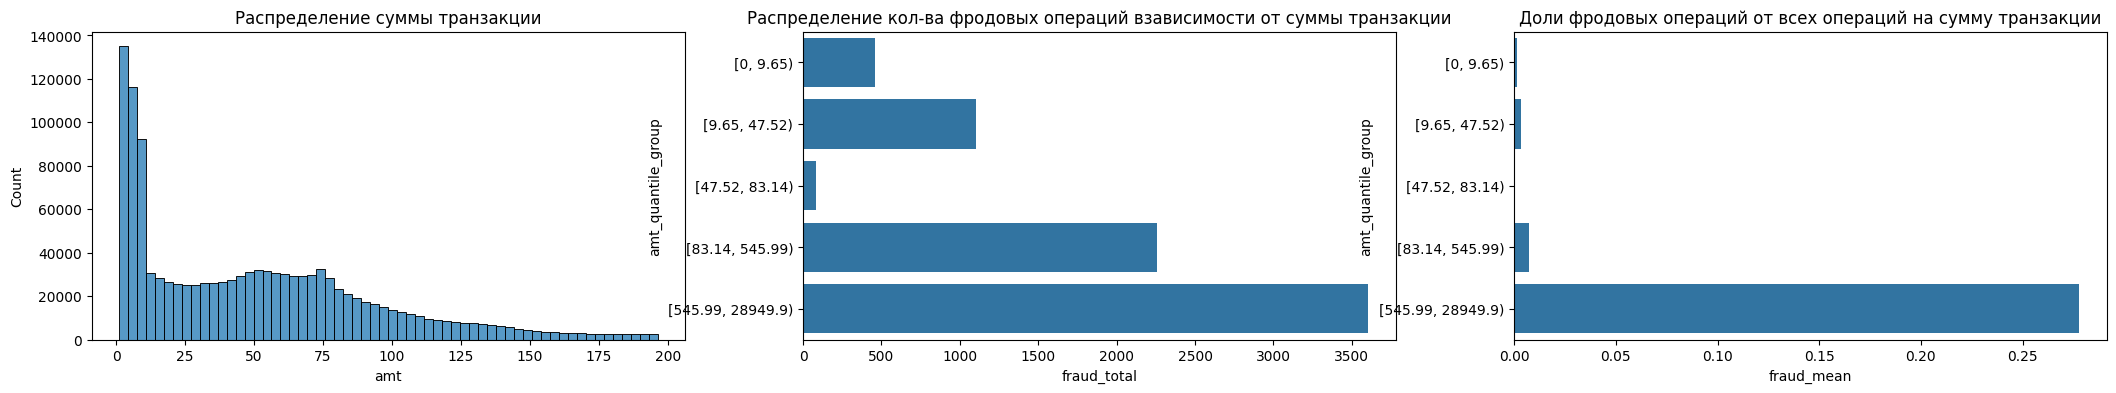

In [20]:
bins = [0, df.amt.quantile(0.25), df.amt.quantile(0.5), df.amt.quantile(0.75), df.amt.quantile(0.99), max(df.amt)+1]
labels = [f'[{np.round(bins[i], 2)}, {np.round(bins[i+1], 2)})' for i in range(0, len(bins)-1)]
df['amt_quantile_group'] = pd.cut(df['amt'], bins=bins, labels=labels, right=False)

tmp = df \
    .groupby('amt_quantile_group', as_index=False) \
    .agg(
        fraud_total=('is_fraud', pd.Series.sum),
        fraud_mean=('is_fraud', pd.Series.mean)
    )

fig, ax = plt.subplots(1, 3, figsize=(26, 4))

sns.histplot(data=df[df.amt < df.amt.quantile(0.95)], x='amt', bins=60, ax=ax[0])
ax[0].set_title('Распределение суммы транзакции')
sns.barplot(data=tmp, x='fraud_total', y='amt_quantile_group', ax=ax[1])
ax[1].set_title('Распределение кол-ва фродовых операций взависимости от суммы транзакции')
sns.barplot(data=tmp, x='fraud_mean', y='amt_quantile_group', ax=ax[2])
ax[2].set_title('Доли фродовых операций от всех операций на сумму транзакции');

Видно, что большее кол-во мошеннических транзакций производится в группе с особо большими суммами, что, в принципе, логично. При этом, каждая четвертая транзакция этой группы является мошеннической.

Рассчитаем 2 типа расстояний:

- Расстояние от дома до места транзакции в километрах;
- Рассстояние от места предыдущей транзакции к месту текущей.

Также рассчитаем время, между текущей транзакцией и прошлой.

In [21]:
@np.vectorize
def get_distance_between_points_on_the_planet_points_on_the_planet(lat_a, long_a, lat_b, long_b):
    lat_a = np.radians(lat_a)
    long_a = np.radians(long_a)
    lat_b = np.radians(lat_b)
    long_b = np.radians(long_b)

    delta_lat = lat_b - lat_a
    delta_long = long_b - long_a

    a = np.pow(np.sin(delta_lat/2), 2) + np.cos(lat_a)*np.cos(lat_b)*np.pow(np.sin(delta_long/2), 2)
    return 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)) * 6371
                       
df['home_to_merch_distance'] = np.round(get_distance_between_points_on_the_planet_points_on_the_planet(df.lat, df.long, df.merch_lat, df.merch_long), 1)

In [22]:
prev_transaction = df \
    .sort_values(['cc_num', 'trans_date_trans_time']) \
    .groupby('cc_num', as_index=False) \
    [['trans_date_trans_time', 'merch_lat', 'merch_long']] \
    .shift(1) \
    .rename(columns={
        'trans_date_trans_time': 'prev_datetime', 
        'merch_lat': 'prev_merch_lat',
        'merch_long': 'prev_merch_long'
        }
    )
df = pd.concat([df, prev_transaction], axis=1)
del prev_transaction

In [23]:
df['prev_trans_timedelta_seconds'] = (df.trans_date_trans_time - df.prev_datetime).dt.total_seconds().clip(lower=60)
df['prev_to_current_transacton_distance'] = np.round(get_distance_between_points_on_the_planet_points_on_the_planet(df.prev_merch_lat, df.prev_merch_long, df.merch_lat, df.merch_long), 1)
df['is_first_transaction'] = df.prev_datetime.isna().astype(int)

Рассчитаем чисто теоретическую скорость, с которой пользователь бы проехал от одной точки транзакции к другой.

In [24]:
df['speed_kmh'] = df.prev_to_current_transacton_distance / (df.prev_trans_timedelta_seconds/3600) #TODO graph

Рассчитаем возраст пользователей. В качестве даты, отностильно которой будем считать возраст будет время последней транзакции.

In [25]:
pd.to_datetime('2020-06-21 12:13:37')

Timestamp('2020-06-21 12:13:37')

In [26]:
last_action = max(df.trans_date_trans_time)
df['age'] = ((last_action - pd.to_datetime(df.dob)).dt.days/365).astype(int)

C:\Users\Shull\AppData\Local\Temp\ipykernel_12960\1408859396.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



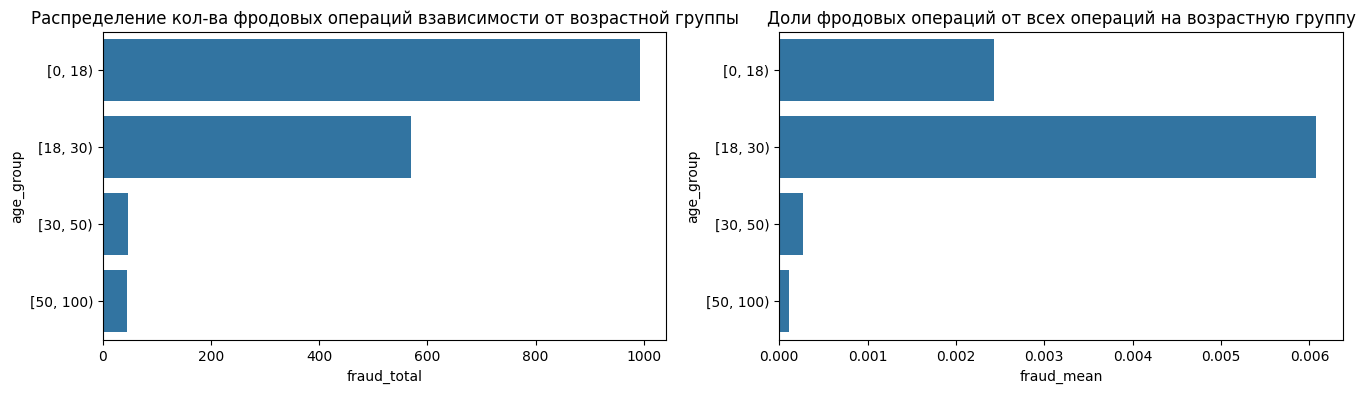

In [27]:
bins = [0, 18, 30, 50, 100]
labels = [f'[{np.round(bins[i], 2)}, {np.round(bins[i+1], 2)})' for i in range(0, len(bins)-1)]
df['age_group'] = pd.cut(df['amt'], bins=bins, labels=labels, right=False)

tmp = df \
    .groupby('age_group', as_index=False) \
    .agg(
        fraud_total=('is_fraud', pd.Series.sum),
        fraud_mean=('is_fraud', pd.Series.mean)
    )

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

sns.barplot(data=tmp, x='fraud_total', y='age_group', ax=ax[0])
ax[0].set_title('Распределение кол-ва фродовых операций взависимости от возрастной группы')
sns.barplot(data=tmp, x='fraud_mean', y='age_group', ax=ax[1])
ax[1].set_title('Доли фродовых операций от всех операций на возрастную группу');

In [28]:
df.groupby('age_group', observed=True, as_index=False).cc_num.size()

,age_group,size
0,"[0, 18)",408170
1,"[18, 30)",93690
2,"[30, 50)",170354
3,"[50, 100)",389514


Посмотрим, а что вообще ночью происходит?

In [29]:
df["is_night"] = ((df.trans_date_trans_time.dt.hour >= 0) & (df.trans_date_trans_time.dt.hour < 6)).astype(int)

In [30]:
df.is_night.value_counts()

is_night
0    1041845
1     254830
Name: count, dtype: int64

is_night
0    1041845
1     254830
Name: count, dtype: int64

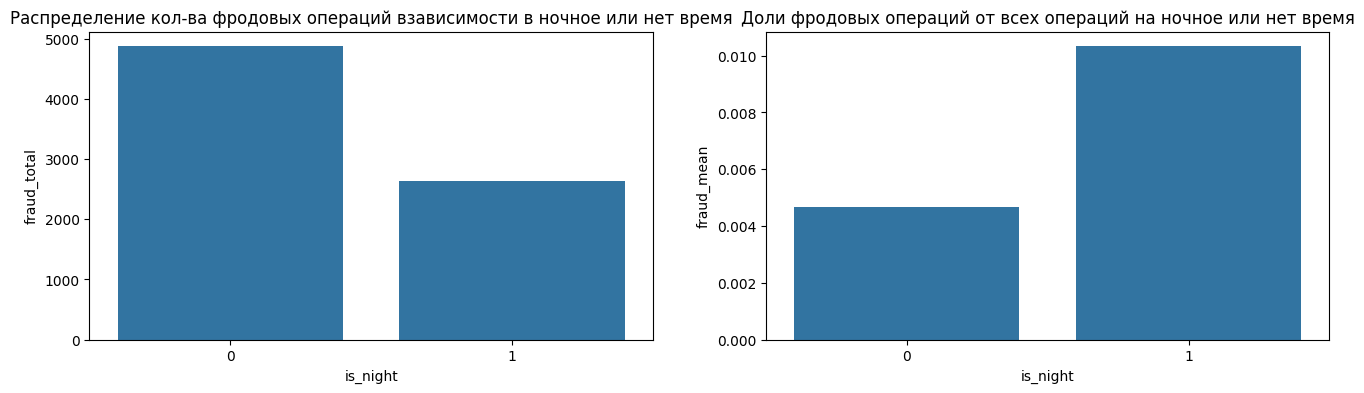

In [31]:
tmp = df \
    .groupby('is_night', as_index=False) \
    .agg(
        fraud_total=('is_fraud', pd.Series.sum),
        fraud_mean=('is_fraud', pd.Series.mean)
    )

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

sns.barplot(data=tmp, x='is_night', y='fraud_total', ax=ax[0])
ax[0].set_title('Распределение кол-ва фродовых операций взависимости в ночное или нет время')
sns.barplot(data=tmp, x='is_night', y='fraud_mean', ax=ax[1])
ax[1].set_title('Доли фродовых операций от всех операций на ночное или нет время')
df.is_night.value_counts()

In [32]:
df[df.is_fraud == 1].groupby('merchant', as_index=False).is_fraud.size().sort_values('size')

,merchant,size
341,fraud_Kub-Heaney,1
482,"fraud_Prosacco, Kreiger and Kovacek",1
56,fraud_Bins-Tillman,1
37,fraud_Bednar Inc,1
5,fraud_Adams-Barrows,1
...,...,...
146,fraud_Doyle Ltd,47
632,fraud_Vandervort-Funk,47
334,fraud_Kozey-Boehm,48
105,fraud_Cormier LLC,48


---

## Подготовка данных и построение моделей.

In [33]:
df = df.drop(columns=['trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last', 
                 'street', 'city', 'state', 'zip', 'lat', 'long', 'job', 
                 'dob', 'trans_num', 'merch_lat', 'unix_time', 'merch_long', 'trans_date',
                 'amt_quantile_group', 'age_group', 'prev_merch_lat', 'prev_merch_long', 'prev_datetime'])

In [34]:
df.prev_to_current_transacton_distance = df.prev_to_current_transacton_distance.fillna(-1)
df.prev_trans_timedelta_seconds = df.prev_trans_timedelta_seconds.fillna(-1)
df.speed_kmh = df.speed_kmh.fillna(0)

df['log_prev_trans_timedelta_seconds'] = np.log1p(df["prev_trans_timedelta_seconds"].clip(lower=0))

df.head()

,category,amt,gender,city_pop,is_fraud,weekday,month,home_to_merch_distance,prev_trans_timedelta_seconds,prev_to_current_transacton_distance,is_first_transaction,speed_kmh,age,is_night,log_prev_trans_timedelta_seconds
0,misc_net,4.97,F,3495,0,Tuesday,January,78.6,-1.0,-1.0,1,0.0,32,1,0.0
1,grocery_pos,107.23,F,149,0,Tuesday,January,30.2,-1.0,-1.0,1,0.0,42,1,0.0
2,entertainment,220.11,M,4154,0,Tuesday,January,108.2,-1.0,-1.0,1,0.0,58,1,0.0
3,gas_transport,45.00,M,1939,0,Tuesday,January,95.7,-1.0,-1.0,1,0.0,53,1,0.0
4,misc_pos,41.96,M,99,0,Tuesday,January,77.6,-1.0,-1.0,1,0.0,34,1,0.0


In [35]:
df.tail()

,category,amt,gender,city_pop,is_fraud,weekday,month,home_to_merch_distance,prev_trans_timedelta_seconds,prev_to_current_transacton_distance,is_first_transaction,speed_kmh,age,is_night,log_prev_trans_timedelta_seconds
1296670,entertainment,15.56,M,258,0,Sunday,June,119.8,16781.0,112.0,0,24.027174,58,0,9.728062
1296671,food_dining,51.70,M,100,0,Sunday,June,75.1,7962.0,95.0,0,42.954032,40,0,8.982561
1296672,food_dining,105.93,M,899,0,Sunday,June,99.0,29074.0,177.1,0,21.928871,52,0,10.277634
1296673,food_dining,74.90,M,1126,0,Sunday,June,84.6,91018.0,119.0,0,4.706761,39,0,11.418824
1296674,food_dining,4.30,M,218,0,Sunday,June,83.9,44250.0,154.7,0,12.585763,24,0,10.697633


<Axes: xlabel='log_prev_trans_timedelta_seconds', ylabel='Count'>

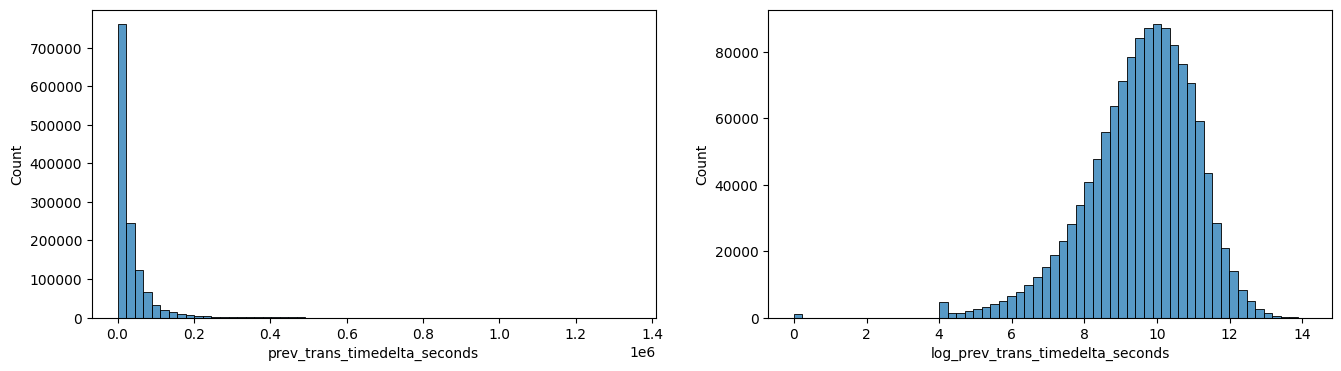

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

sns.histplot(data=df, x='prev_trans_timedelta_seconds', bins=60, ax=ax[0])
sns.histplot(data=df, x='log_prev_trans_timedelta_seconds', bins=60, ax=ax[1])

<Axes: xlabel='city_pop', ylabel='Count'>

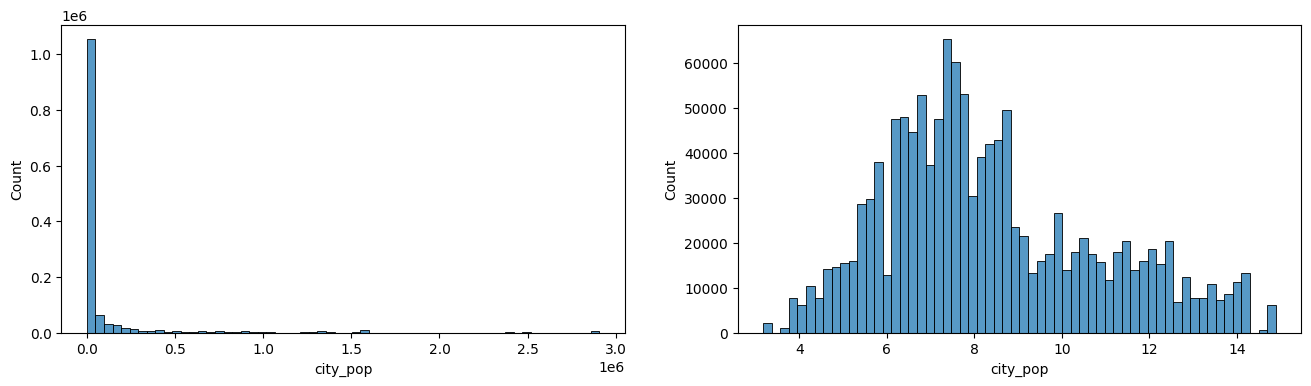

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

sns.histplot(data=df, x='city_pop', bins=60, ax=ax[0])
sns.histplot(x=np.log1p(df.city_pop), bins=60, ax=ax[1])

<Axes: xlabel='amt', ylabel='Count'>

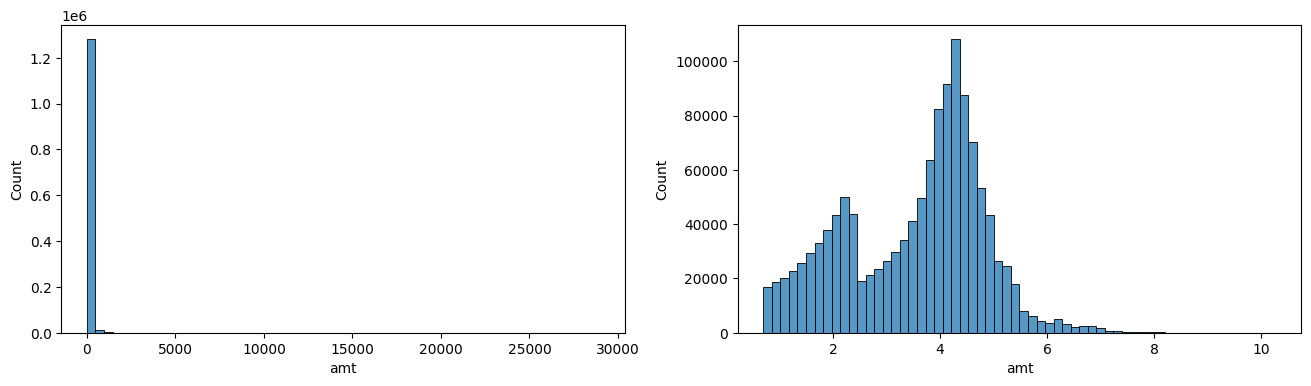

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

sns.histplot(data=df, x='amt', bins=60, ax=ax[0])
sns.histplot(x=np.log1p(df.amt), bins=60, ax=ax[1])

<Axes: xlabel='speed_kmh', ylabel='Count'>

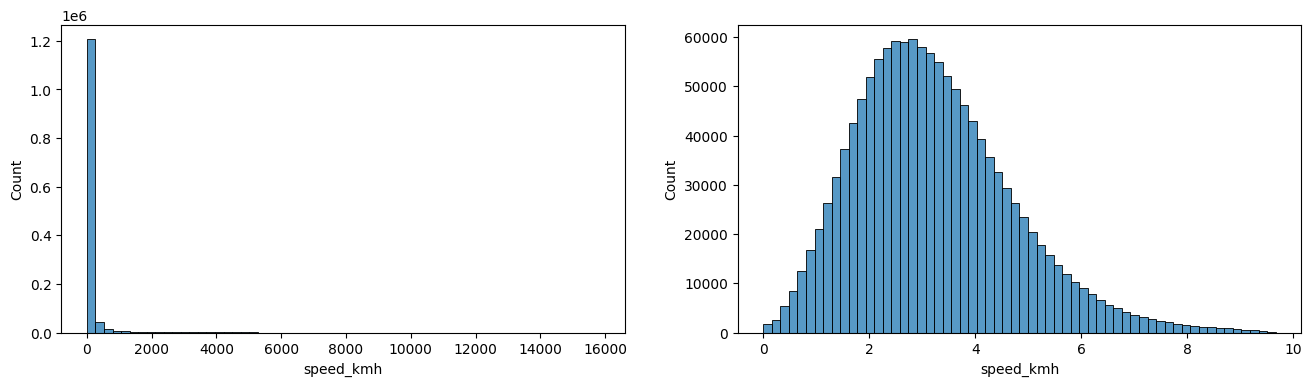

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

sns.histplot(data=df, x='speed_kmh', bins=60, ax=ax[0])
sns.histplot(x=np.log1p(df.speed_kmh), bins=60, ax=ax[1])

<Axes: xlabel='speed_kmh', ylabel='Count'>

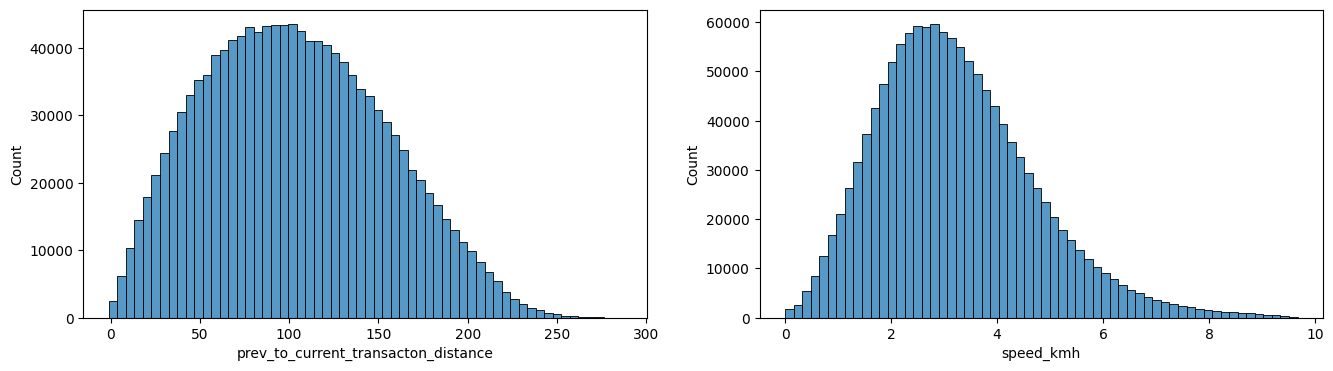

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

sns.histplot(data=df, x='prev_to_current_transacton_distance', bins=60, ax=ax[0])
sns.histplot(x=np.log1p(df.speed_kmh), bins=60, ax=ax[1])

In [41]:
df['log_amt'] = np.log1p(df.amt)
df['log_city_pop'] = np.log1p(df.city_pop)
df['log_speed'] = np.log1p(df.speed_kmh)

df = df.drop(columns=['amt', 'city_pop', 'prev_trans_timedelta_seconds', 'speed_kmh'])
df.head()

,category,gender,is_fraud,weekday,month,home_to_merch_distance,prev_to_current_transacton_distance,is_first_transaction,age,is_night,log_prev_trans_timedelta_seconds,log_amt,log_city_pop,log_speed
0,misc_net,F,0,Tuesday,January,78.6,-1.0,1,32,1,0.0,1.786747,8.159375,0.0
1,grocery_pos,F,0,Tuesday,January,30.2,-1.0,1,42,1,0.0,4.684259,5.010635,0.0
2,entertainment,M,0,Tuesday,January,108.2,-1.0,1,58,1,0.0,5.398660,8.332068,0.0
3,gas_transport,M,0,Tuesday,January,95.7,-1.0,1,53,1,0.0,3.828641,7.570443,0.0
4,misc_pos,M,0,Tuesday,January,77.6,-1.0,1,34,1,0.0,3.760269,4.605170,0.0


In [104]:
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_state, shuffle=True, stratify=y)

Чтобы нормализовать данные в столбце prev_to_current_transacton_distance реализуем новый класс. Причиной этому служит наличие -1 в столбце, которое влияет на мат. ожидание и дисперсию, поэтому -1 будут просто игнорироваться при трансформации.

In [44]:
class RobustScalerIgnoreValue(BaseEstimator, TransformerMixin):
    def __init__(self, ignore_value=-1):
        self.ignore_value = ignore_value
        self.scaler = RobustScaler()

    def fit(self, X, y=None):
        X = np.asarray(X).reshape(-1, 1)
        mask = X[:, 0] != self.ignore_value
        self.scaler.fit(X[mask])
        return self

    def transform(self, X):
        X = np.asarray(X).reshape(-1, 1)
        X_out = X.copy()
        mask = X[:, 0] != self.ignore_value
        X_out[mask] = self.scaler.transform(X[mask])
        return X_out

In [45]:
not_flags = ['home_to_merch_distance', 'age', 'log_speed', 'log_amt', 'log_city_pop', 'log_prev_trans_timedelta_seconds']
categorical = ['category', 'gender', 'weekday', 'month']

ct = ColumnTransformer(
    [
        ('robust_scaler', RobustScaler(), not_flags),
        ('OHE', OneHotEncoder(), categorical),
        ('RobustScalerIgnoreValue', RobustScalerIgnoreValue(), ['prev_to_current_transacton_distance'])
    ]
)

Первой моделью будет логистическая регрессия в качестве некоего бейзлайна. Параметры будем подбирать с помощью optuna по кроссвалидации. В качестве метрики, для выбора параметров будет служить AP(average_precision). Порог для отнесения транзакции к фроду можно подбирать разными способами, все зависит от бизнес задачи и ресурсов, например, сколько подозрительных транзакций мы можем вручную проверить и тп. В данной задаче, например, буду считать порог по FPR (стрельбе по хорошим транзакциям) и стараться, чтобы их было максимум 0.005 (0.5%) от всех наших выстрелов.

In [46]:
logreg_pipeline = Pipeline(
    steps=(
        ('transforms', ct),
        ('model', LogisticRegression(penalty='l2', solver='liblinear'))
    )
)

In [47]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
def objective(trial):
    params = {
        "model__C": trial.suggest_float("C", 1e-4, 1000),
    }
    ap_scores_train, ap_scores_val = [], []

    logreg_pipeline.set_params(**params)
    for train_idx, valid_idx in cv.split(X, y):
        X_tr, X_vl = X.loc[train_idx, :], X.loc[valid_idx, :]
        y_tr, y_vl = y[train_idx], y[valid_idx]

        logreg_pipeline.fit(X_tr, y_tr)
        proba_train = logreg_pipeline.predict_proba(X_tr)[:, 1]
        proba_val = logreg_pipeline.predict_proba(X_vl)[:, 1]

        ap_scores_train.append(average_precision_score(y_tr, proba_train))
        ap_scores_val.append(average_precision_score(y_vl, proba_val))
    trial.set_user_attr("train_ap_cv", np.mean(ap_scores_train))

    return np.mean(ap_scores_val)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
best = study.best_trial
best.user_attrs["train_ap_cv"]

[I 2026-02-02 12:03:42,631] A new study created in memory with name: no-name-1a70617e-787f-4df6-bcdb-454116b00037
[I 2026-02-02 12:04:05,234] Trial 0 finished with value: 0.32007977230954887 and parameters: {'C': 379.2391378318968}. Best is trial 0 with value: 0.32007977230954887.
[I 2026-02-02 12:04:28,326] Trial 1 finished with value: 0.32007914560067635 and parameters: {'C': 398.3367102244265}. Best is trial 0 with value: 0.32007977230954887.
[I 2026-02-02 12:04:50,612] Trial 2 finished with value: 0.3200773684028194 and parameters: {'C': 98.08985660155916}. Best is trial 0 with value: 0.32007977230954887.
[I 2026-02-02 12:05:13,554] Trial 3 finished with value: 0.3200796704409472 and parameters: {'C': 344.91308300548053}. Best is trial 0 with value: 0.32007977230954887.
[I 2026-02-02 12:05:36,238] Trial 4 finished with value: 0.32008056429042087 and parameters: {'C': 691.6220790900155}. Best is trial 4 with value: 0.32008056429042087.
[I 2026-02-02 12:05:58,643] Trial 5 finished wi

np.float64(0.3202519161916636)

In [48]:
best_params_logreg = {
f"model__{k}": v
for k, v in study.best_params.items()
}

В качестве второй модели будет random_forest. Все, что было сказано про параметры и метрику качества в logreg модели относится и сюда.

In [49]:
random_forest_pipeline = Pipeline(
    steps=(
        ('transforms', ct),
        ('model', RandomForestClassifier(n_jobs=-1, random_state=random_state, class_weight="balanced"))
    )
)

In [50]:
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=random_state)
def objective(trial):
    params = {
        "model__n_estimators": trial.suggest_int("n_estimators", 10, 300),
        "model__max_depth": trial.suggest_int("max_depth", 5, 25),
        "model__min_samples_split": trial.suggest_int("min_samples_split", 50, 3000),
        "model__min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 1000),
    }
    ap_scores_train, ap_scores_val = [], []

    random_forest_pipeline.set_params(**params)
    for train_idx, valid_idx in cv.split(X, y):
        X_tr, X_vl = X.loc[train_idx, :], X.loc[valid_idx, :]
        y_tr, y_vl = y[train_idx], y[valid_idx]

        random_forest_pipeline.fit(X_tr, y_tr)
        proba_train = random_forest_pipeline.predict_proba(X_tr)[:, 1]
        proba_val = random_forest_pipeline.predict_proba(X_vl)[:, 1]

        ap_scores_train.append(average_precision_score(y_tr, proba_train))
        ap_scores_val.append(average_precision_score(y_vl, proba_val))
    trial.set_user_attr("train_ap_cv", np.mean(ap_scores_train))

    return np.mean(ap_scores_val)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)
best = study.best_trial
best.user_attrs["train_ap_cv"]

[I 2026-02-02 12:23:42,263] A new study created in memory with name: no-name-e47fe4f6-7f9e-4c90-834d-5cdf8e643a8e
[I 2026-02-02 12:23:57,999] Trial 0 finished with value: 0.4330074228296841 and parameters: {'n_estimators': 46, 'max_depth': 5, 'min_samples_split': 1776, 'min_samples_leaf': 971}. Best is trial 0 with value: 0.4330074228296841.
[I 2026-02-02 12:25:16,021] Trial 1 finished with value: 0.5982499307380603 and parameters: {'n_estimators': 170, 'max_depth': 11, 'min_samples_split': 2309, 'min_samples_leaf': 517}. Best is trial 1 with value: 0.5982499307380603.
[I 2026-02-02 12:26:41,117] Trial 2 finished with value: 0.6044102080933419 and parameters: {'n_estimators': 219, 'max_depth': 9, 'min_samples_split': 1569, 'min_samples_leaf': 372}. Best is trial 2 with value: 0.6044102080933419.
[I 2026-02-02 12:28:07,941] Trial 3 finished with value: 0.605408285092875 and parameters: {'n_estimators': 278, 'max_depth': 7, 'min_samples_split': 121, 'min_samples_leaf': 195}. Best is tria

np.float64(0.8093555185643995)

In [51]:
best_params_random_forest = {
f"model__{k}": v
for k, v in study.best_params.items()
}
best_params_random_forest

{'model__n_estimators': 119,
 'model__max_depth': 18,
 'model__min_samples_split': 812,
 'model__min_samples_leaf': 10}

Подберем кол-во деревьев в ансамбле.

In [52]:
random_forest_pipeline.set_params(**best_params_random_forest)

results = []
for n in tqdm(range(10, 250, 10)):
    random_forest_pipeline.set_params(model__n_estimators=n)
    random_forest_pipeline.fit(X_train, y_train)
    
    train_preds = random_forest_pipeline.predict_proba(X_train)[:, 1]
    val_preds = random_forest_pipeline.predict_proba(X_val)[:, 1]

    ap_train = average_precision_score(y_train, train_preds)
    ap_val = average_precision_score(y_val, val_preds)

    results.append([ap_train, ap_val])
    
results = pd.DataFrame(results, columns=['train', 'test'])
results['i'] = np.arange(10, 250, 10)
results.head()

100%|██████████| 24/24 [48:26<00:00, 121.10s/it]


,train,test,i
0,0.735354,0.679979,10
1,0.771311,0.698171,20
2,0.779540,0.709986,30
3,0.785713,0.711529,40
4,0.793583,0.721958,50


In [53]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=results['i'], y=results['train'],
                    mode='lines+markers',
                    name='lines+markers'))

fig.add_trace(go.Scatter(x=results['i'], y=results['test'],
                    mode='lines+markers',
                    name='lines+markers'))

fig.update_layout(
    autosize=False,
    width=1000,
    height=500
)
fig.show()

In [54]:
best_params_random_forest['model__n_estimators'] = 200

Финальной моделью будет CatBoostClassifier. В данном случаем обработку категориальных фичей оставляем модели. Подбор параметров будет проходить в несколько этапов. В первом этапе подбираем lr, который отвечает за длину шага во время градиентного спуска, а также подбираем глубину дерева. При этом, количество деревьев в бустинге ставим большое и передаем параметр, отвечающий за остановку обучения бустинга при неуменьшении лосса.

In [55]:
gb_ct = ColumnTransformer(
    [
        ('cat', 'passthrough', categorical),
        ('robust_scaler', RobustScaler(), not_flags),
        ('RobustScalerIgnoreValue', RobustScalerIgnoreValue(), ['prev_to_current_transacton_distance'])
    ]
)

X_train_transformed = gb_ct.fit_transform(X_train)
X_val_transformed = gb_ct.transform(X_val)
best_params_catboost = {
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'iterations': 2000,
    'l2_leaf_reg': 3,
    'random_strength': 1,
    'bagging_temperature': 1,
    'verbose': False,
    'random_seed': random_state,
    'use_best_model': True,
    'task_type': 'GPU',
    'cat_features': list(range(len(categorical)))
}

In [57]:
params = best_params_catboost.copy()

def objective(trial):
    params.update({        
        "depth": trial.suggest_categorical("depth", [6, 10]),
        "learning_rate": trial.suggest_float('learning_rate', 2e-3, 0.3, log=True)
    })
    
    catboost_model = CatBoostClassifier(
        **params
    )

    catboost_model.fit(
        X_train_transformed, y_train,
        eval_set=(X_val_transformed, y_val),
        early_stopping_rounds=50

    )

    proba_train = catboost_model.predict_proba(X_train_transformed)[:, 1]
    proba_val = catboost_model.predict_proba(X_val_transformed)[:, 1]

    ap_train = average_precision_score(y_train, proba_train)
    ap_val = average_precision_score(y_val, proba_val)
    trial.set_user_attr("train_ap_cv", ap_train)

    return ap_val

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
best = study.best_trial
best.user_attrs["train_ap_cv"]

[I 2026-02-02 14:09:44,205] A new study created in memory with name: no-name-0c7fcc54-e101-4145-b21f-82e6b1ce3de0
[I 2026-02-02 14:10:13,228] Trial 0 finished with value: 0.849089586721252 and parameters: {'depth': 6, 'learning_rate': 0.2741429471184217}. Best is trial 0 with value: 0.849089586721252.
[I 2026-02-02 14:12:53,678] Trial 1 finished with value: 0.8185148195655093 and parameters: {'depth': 10, 'learning_rate': 0.004295038786326179}. Best is trial 0 with value: 0.849089586721252.
[I 2026-02-02 14:15:31,485] Trial 2 finished with value: 0.8140203315651486 and parameters: {'depth': 10, 'learning_rate': 0.003583911365883255}. Best is trial 0 with value: 0.849089586721252.
[I 2026-02-02 14:18:11,678] Trial 3 finished with value: 0.802918616603583 and parameters: {'depth': 10, 'learning_rate': 0.002353810596824164}. Best is trial 0 with value: 0.849089586721252.
[I 2026-02-02 14:20:56,396] Trial 4 finished with value: 0.8245871130687741 and parameters: {'depth': 10, 'learning_rat

0.9377661183667301

Определяем, какое кол-во деревьев при фиксированных значениях нам понадобится.

In [59]:
best_params_catboost

{'loss_function': 'Logloss',
 'eval_metric': 'Logloss',
 'iterations': 2000,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'bagging_temperature': 1,
 'verbose': False,
 'random_seed': 33,
 'use_best_model': True,
 'task_type': 'GPU',
 'cat_features': [0, 1, 2, 3],
 'depth': 6,
 'learning_rate': 0.06525616741864301}

In [60]:
best_params_catboost.update(study.best_params)
params = best_params_catboost.copy()
del params['task_type'] #PRAUC не умеет в ГПУ

catboost_model = CatBoostClassifier(
    **params,
    custom_loss=['PRAUC']
)

catboost_model.fit(
    X_train_transformed, y_train,
    eval_set=(X_val_transformed, y_val),
    early_stopping_rounds=50,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [61]:
best_params_catboost['iterations'] = 1000
del best_params_catboost['eval_metric']
del best_params_catboost['use_best_model']

best_params_catboost

{'loss_function': 'Logloss',
 'iterations': 1000,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'bagging_temperature': 1,
 'verbose': False,
 'random_seed': 33,
 'task_type': 'GPU',
 'cat_features': [0, 1, 2, 3],
 'depth': 6,
 'learning_rate': 0.06525616741864301}

Дальше по кросс-валидации подбираем оставшиеся параметры, которые сильнее всего влияют на качество модели.

In [62]:
params = best_params_catboost.copy()
X_transformed = gb_ct.fit_transform(X)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

def objective(trial):
    params.update({
        "random_strength": trial.suggest_float("random_strength", 1e-5, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 30),
        "bagging_temperature": trial.suggest_float('bagging_temperature', 0, 1),
        "scale_pos_weight": trial.suggest_categorical("scale_pos_weight", [1, 171])
    })
    
    ap_scores_train, ap_scores_val = [], []

    catboost_model = CatBoostClassifier(**params)
    for train_idx, valid_idx in cv.split(X_transformed, y):
        X_tr, X_vl = X.loc[train_idx, :], X.loc[valid_idx, :]
        y_tr, y_vl = y[train_idx], y[valid_idx]

        catboost_model.fit(X_tr, y_tr)
        proba_train = catboost_model.predict_proba(X_tr)[:, 1]
        proba_val = catboost_model.predict_proba(X_vl)[:, 1]

        ap_scores_train.append(average_precision_score(y_tr, proba_train))
        ap_scores_val.append(average_precision_score(y_vl, proba_val))
    trial.set_user_attr("train_ap_cv", np.mean(ap_scores_train))

    return np.mean(ap_scores_val)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
best = study.best_trial
best.user_attrs["train_ap_cv"]

[I 2026-02-02 15:23:55,184] A new study created in memory with name: no-name-47b135a8-651c-46f7-bc95-e6d59f00144f
[I 2026-02-02 15:25:19,406] Trial 0 finished with value: 0.8611807424022215 and parameters: {'random_strength': 7.356324122932794, 'l2_leaf_reg': 12.633861536669176, 'bagging_temperature': 0.9526085910588226, 'scale_pos_weight': 171}. Best is trial 0 with value: 0.8611807424022215.
[I 2026-02-02 15:26:46,957] Trial 1 finished with value: 0.8732073626937797 and parameters: {'random_strength': 9.765572106662338, 'l2_leaf_reg': 19.314251342965104, 'bagging_temperature': 0.5027912148120759, 'scale_pos_weight': 1}. Best is trial 1 with value: 0.8732073626937797.
[I 2026-02-02 15:28:10,765] Trial 2 finished with value: 0.8664855468590975 and parameters: {'random_strength': 2.8619511050226802, 'l2_leaf_reg': 3.276136526869897, 'bagging_temperature': 0.5574384777431205, 'scale_pos_weight': 171}. Best is trial 1 with value: 0.8732073626937797.
[I 2026-02-02 15:29:37,656] Trial 3 fin

np.float64(0.9332737224427253)

In [63]:
del X_train_transformed, X_val_transformed


best_params_catboost.update(study.best_params)
del best_params_catboost['task_type']

best_params_catboost = {
f"model__{k}": v
for k, v in best_params_catboost.items()
}

catboost_pipeline = Pipeline(
    steps=(
        ('transforms', gb_ct),
        ('model', CatBoostClassifier())
    )
)

In [65]:
logreg_pipeline.set_params(**best_params_logreg)
random_forest_pipeline.set_params(**best_params_random_forest)
catboost_pipeline.set_params(**best_params_catboost)

logreg_pipeline.fit(X_train, y_train)
random_forest_pipeline.fit(X_train, y_train)
catboost_pipeline.fit(X_train, y_train);

---

In [111]:
# Чтобы не учить постоянно
not_flags = ['home_to_merch_distance', 'age', 'log_speed', 'log_amt', 'log_city_pop', 'log_prev_trans_timedelta_seconds']
categorical = ['category', 'gender', 'weekday']

best_params_catboost = {'model__loss_function': 'Logloss',
 'model__iterations': 1000,
 'model__l2_leaf_reg': 0.8302587439039577,
 'model__random_strength': 2.180072000390749,
 'model__bagging_temperature': 0.3443574112884204,
 'model__verbose': False,
 'model__random_seed': 33,
 'model__cat_features': list(range(len(categorical))),
 'model__depth': 6,
 'model__learning_rate': 0.06525616741864301,
 'model__scale_pos_weight': 1}

best_params_random_forest = {
'model__n_estimators': 200,
 'model__max_depth': 18,
 'model__min_samples_split': 812,
 'model__min_samples_leaf': 10}

best_params_logreg = {
    'model__C': 854.9051230528536
}

In [112]:
class RobustScalerIgnoreValue(BaseEstimator, TransformerMixin):
    def __init__(self, ignore_value=-1):
        self.ignore_value = ignore_value
        self.scaler = RobustScaler()

    def fit(self, X, y=None):
        X = np.asarray(X).reshape(-1, 1)
        mask = X[:, 0] != self.ignore_value
        self.scaler.fit(X[mask])
        return self

    def transform(self, X):
        X = np.asarray(X).reshape(-1, 1)
        X_out = X.copy()
        mask = X[:, 0] != self.ignore_value
        X_out[mask] = self.scaler.transform(X[mask])
        return X_out

ct = ColumnTransformer(
    [
        ('robust_scaler', RobustScaler(), not_flags),
        ('OHE', OneHotEncoder(), categorical),
        ('RobustScalerIgnoreValue', RobustScalerIgnoreValue(), ['prev_to_current_transacton_distance'])
    ]
)

gb_ct = ColumnTransformer(
    [
        ('cat', 'passthrough', categorical),
        ('robust_scaler', RobustScaler(), not_flags),
        ('RobustScalerIgnoreValue', RobustScalerIgnoreValue(), ['prev_to_current_transacton_distance'])
    ]
)

In [113]:
logreg_pipeline = Pipeline(
    steps=(
        ('transforms', ct),
        ('model', LogisticRegression(penalty='l2', solver='liblinear'))
    )
)

random_forest_pipeline = Pipeline(
    steps=(
        ('transforms', ct),
        ('model', RandomForestClassifier(n_jobs=-1, random_state=random_state, class_weight="balanced"))
    )
)

catboost_pipeline = Pipeline(
    steps=(
        ('transforms', gb_ct),
        ('model', CatBoostClassifier())
    )
)

logreg_pipeline.set_params(**best_params_logreg)
random_forest_pipeline.set_params(**best_params_random_forest)
catboost_pipeline.set_params(**best_params_catboost)

logreg_pipeline.fit(X_train, y_train)
random_forest_pipeline.fit(X_train, y_train)
catboost_pipeline.fit(X_train, y_train);

---

Подберем threshold для моделей.

In [114]:
target_fpr = 0.001

proba = catboost_pipeline.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, proba)

# берём самый большой threshold, при котором FPR <= target_fpr
idx = np.where(fpr <= target_fpr)[0][-1]
catboost_threshold = thresholds[idx]
catboost_threshold

np.float64(0.34363619149910446)

In [115]:
proba = random_forest_pipeline.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, proba)

# берём самый большой threshold, при котором FPR <= target_fpr
idx = np.where(fpr <= target_fpr)[0][-1]
random_forest_threshold = thresholds[idx]
random_forest_threshold

np.float64(0.9260454745064757)

In [116]:
proba = logreg_pipeline.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, proba)

# берём самый большой threshold, при котором FPR <= target_fpr
idx = np.where(fpr <= target_fpr)[0][-1]
logreg_threshold = thresholds[idx]
logreg_threshold

np.float64(0.3075292543074643)

In [117]:
def show(models: list[dict], X, y):
    fig = plt.figure(figsize=(12, 10))
    gs = GridSpec(2, 4, figure=fig)

    ax1 = plt.subplot(gs[0, :2])
    ax2 = fig.add_subplot(gs[0, 2:])
    ax3 = fig.add_subplot(gs[1, :])
    
    metrics_table = {}
    indexes = ['threshold', 'FP', 'TP', 'FN', 'TN', 'Precision', 'Recall', 'Acc', 'FPR', 'FNR', 'AP']
    for name, model in models.items():
        model, threshold = model
        PrecisionRecallDisplay.from_estimator(model, 
                                                X, y,
                                                ax=ax1, 
                                                name=name)
        RocCurveDisplay.from_estimator(model, 
                                         X, y,
                                         ax=ax2, 
                                         name=name)
        
        y_pred = model.predict_proba(X)[:, 1]
        tn, fp, fn, tp = confusion_matrix(y, y_pred >= threshold).ravel().tolist()
        
        metrics = [threshold, fp, tp, fn, tn]
        metrics.append(tp/(tp + fp))
        metrics.append(tp/(tp + fn))
        metrics.append((tp+tn)/(tp+fn+fp+tn))
        metrics.append(fp/(fp+tn))
        metrics.append(fn/(fn+tp))
        metrics.append(average_precision_score(y, y_pred))
        metrics_table.update({name: metrics})
        
    metrics_table =  pd.DataFrame(data=metrics_table, index=indexes).T
    metrics_table = np.round(metrics_table, 2)
    ax3.axis('off')
    ax3.axis('tight')
    ax3.table(metrics_table, loc='center')
    plt.tight_layout()

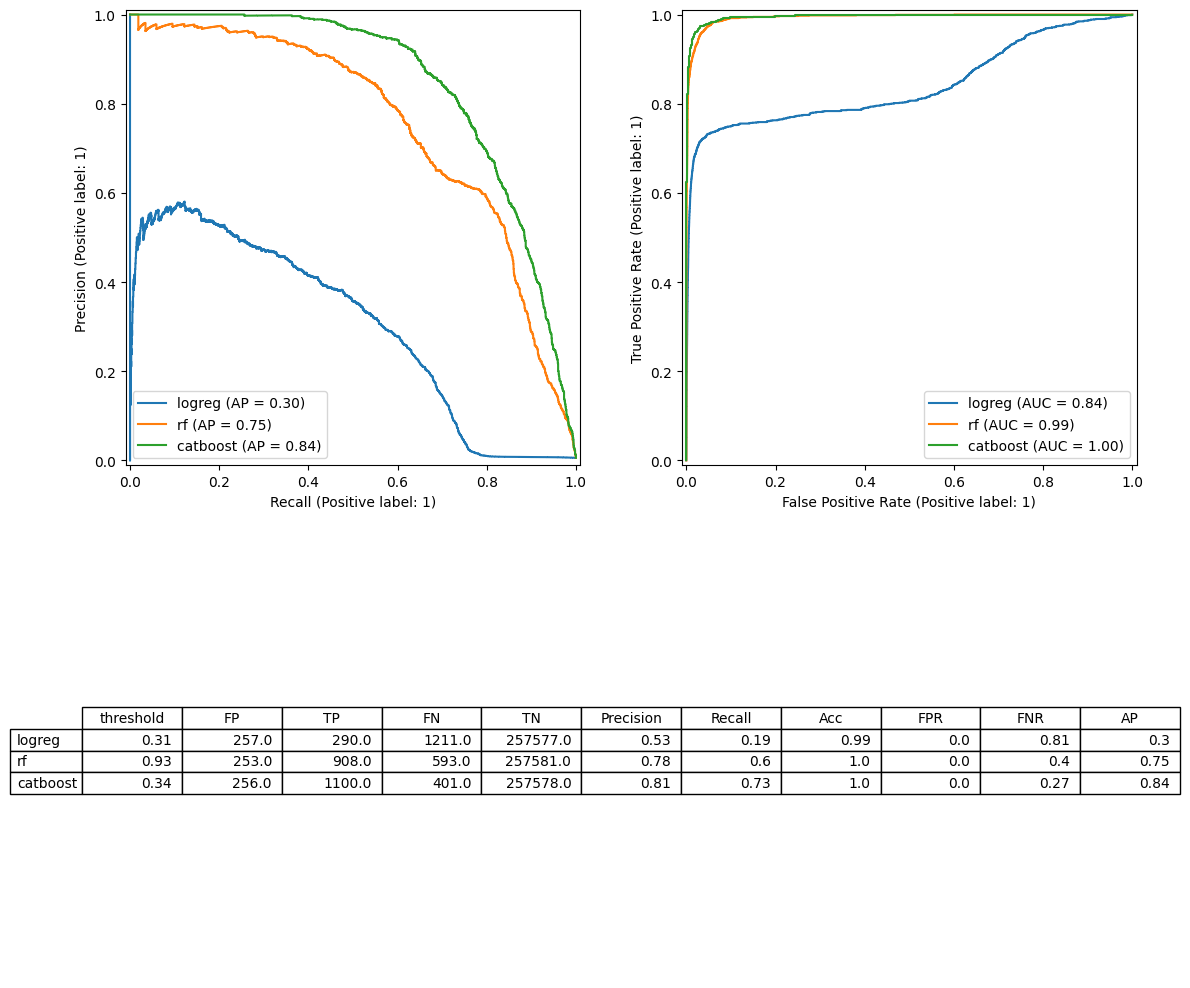

In [118]:
show({'logreg': (logreg_pipeline, logreg_threshold), 
      'rf': (random_forest_pipeline, random_forest_threshold),
      'catboost': (catboost_pipeline, catboost_threshold)}, X_val, y_val)

Обучим на всём train'e и сохраним catboost.

In [71]:
catboost_pipeline.fit(X, y)

artifact = {
    "pipeline": catboost_pipeline,
    "threshold": catboost_threshold,
    "model_name": "catboost_fraud",
}

joblib.dump(artifact, './models/' + artifact['model_name'] + '.joblib')

['./models/catboost_fraud.joblib']

Реализуем для удобства класс, который будет проделывать все шаги от обработки данных, до прогонки их через модель и выдачу предсказаний.

In [81]:
class RobustScalerIgnoreValue(BaseEstimator, TransformerMixin):
    def __init__(self, ignore_value=-1):
        self.ignore_value = ignore_value
        self.scaler = RobustScaler()

    def fit(self, X, y=None):
        X = np.asarray(X).reshape(-1, 1)
        mask = X[:, 0] != self.ignore_value
        self.scaler.fit(X[mask])
        return self

    def transform(self, X):
        X = np.asarray(X).reshape(-1, 1)
        X_out = X.copy()
        mask = X[:, 0] != self.ignore_value
        X_out[mask] = self.scaler.transform(X[mask])
        return X_out

class FraudPreprocessor:
    def __init__(self, last_action=pd.to_datetime('2020-06-21 12:13:37'),):
        self.last_action=last_action
        
    def __call__(self, *args, **kwds):
        return self.transform(*args, **kwds)
    
    def transform(self, X):
        X['weekday'] = X.trans_date_trans_time.dt.strftime("%A")
        X['month'] = X.trans_date_trans_time.dt.month_name()
        
        X['home_to_merch_distance'] = np.round(
            self.get_distance_between_points_on_the_planet_points_on_the_planet(
                X.lat, X.long, X.merch_lat, X.merch_long
            ), 1
        )

        prev_transaction = X \
            .sort_values(['cc_num', 'trans_date_trans_time']) \
            .groupby('cc_num', as_index=False) \
            [['trans_date_trans_time', 'merch_lat', 'merch_long']] \
            .shift(1) \
            .rename(columns={
                'trans_date_trans_time': 'prev_datetime', 
                'merch_lat': 'prev_merch_lat',
                'merch_long': 'prev_merch_long'
                }
        )
        X = pd.concat([X, prev_transaction], axis=1)
        del prev_transaction

        X['prev_trans_timedelta_seconds'] = (X.trans_date_trans_time - X.prev_datetime).dt.total_seconds().clip(lower=60)

        X['prev_to_current_transacton_distance'] = np.round(
            self.get_distance_between_points_on_the_planet_points_on_the_planet(
                X.prev_merch_lat, X.prev_merch_long, X.merch_lat, X.merch_long
            ), 1
        )

        X['is_first_transaction'] = X.prev_datetime.isna().astype(int)
        X['speed_kmh'] = X.prev_to_current_transacton_distance / (X.prev_trans_timedelta_seconds/3600)
        X['age'] = ((self.last_action - pd.to_datetime(X.dob)).dt.days/365).astype(int)
        X["is_night"] = ((X.trans_date_trans_time.dt.hour >= 0) & (X.trans_date_trans_time.dt.hour < 6)).astype(int)

        X = X.drop(columns=['trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last', 
                 'street', 'city', 'state', 'zip', 'lat', 'long', 'job', 
                 'dob', 'trans_num', 'merch_lat', 'unix_time', 'merch_long',
                 'prev_merch_lat', 'prev_merch_long', 'prev_datetime'])
        
        X.prev_to_current_transacton_distance = X.prev_to_current_transacton_distance.fillna(-1)
        X.prev_trans_timedelta_seconds = X.prev_trans_timedelta_seconds.fillna(-1)
        X.speed_kmh = X.speed_kmh.fillna(0)

        X['log_prev_trans_timedelta_seconds'] = np.log1p(X["prev_trans_timedelta_seconds"].clip(lower=0))
        X['log_amt'] = np.log1p(X.amt)
        X['log_city_pop'] = np.log1p(X.city_pop)
        X['log_speed'] = np.log1p(X.speed_kmh)
        X = X.drop(columns=['amt', 'city_pop', 'prev_trans_timedelta_seconds', 'speed_kmh'])
        return X

    @staticmethod
    @np.vectorize
    def get_distance_between_points_on_the_planet_points_on_the_planet(lat_a, long_a, lat_b, long_b):
        lat_a = np.radians(lat_a)
        long_a = np.radians(long_a)
        lat_b = np.radians(lat_b)
        long_b = np.radians(long_b)

        delta_lat = lat_b - lat_a
        delta_long = long_b - long_a

        a = np.pow(np.sin(delta_lat/2), 2) + np.cos(lat_a)*np.cos(lat_b)*np.pow(np.sin(delta_long/2), 2)
        return 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)) * 6371


In [82]:
class FraudInference:
    def __init__(self, models_path='./models/', weights_file_name='catboost_fraud.joblib'):
        self.models_path = models_path
        self.weights_file_name = weights_file_name
        artifact = joblib.load(models_path+weights_file_name)
        self.pipeline = artifact['pipeline']
        self.threshold = artifact['threshold']
        self.preprocessor = FraudPreprocessor()

    def predict_proba(self, X):
        X = self.preprocessor(X)
        return self.pipeline.predict_proba(X)

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba >= self.threshold).astype(int)

In [119]:
test = pd.read_csv('./data/fraudTest.csv', index_col=0, parse_dates=['trans_date_trans_time'])
X_test = test.drop(columns='is_fraud')
y_test = test['is_fraud']

In [120]:
model = FraudInference()

In [121]:
y_pred = model.predict_proba(X_test)[:, 1]
tn, fp, fn, tp = confusion_matrix(y_test, y_pred >= model.threshold).ravel().tolist()
indexes = ['threshold', 'FP', 'TP', 'FN', 'TN', 'Precision', 'Recall', 'Acc', 'FPR', 'FNR', 'AP']
metrics = [model.threshold, fp, tp, fn, tn]
metrics.append(tp/(tp + fp))
metrics.append(tp/(tp + fn))
metrics.append((tp+tn)/(tp+fn+fp+tn))
metrics.append(fp/(fp+tn))
metrics.append(fn/(fn+tp))
metrics.append(average_precision_score(y_test, y_pred))

for i, m in zip(indexes, metrics):
    print(i, m)

threshold 0.3307544988049139
FP 586
TP 1460
FN 685
TN 552988
Precision 0.7135874877810362
Recall 0.6806526806526807
Acc 0.9977128728728009
FPR 0.0010585757279062962
FNR 0.31934731934731936
AP 0.7721279315249029


FPR остался на заданном уровне.

Проведен детальный разведочный анализ данных кредитных транзакций, выявивший статистически значимую зависимость фрода от пола, категории товаров, суммы и времени транзакции.

Сгенерированы новые признаки, улучшающие разделимость классов: расстояние от дома до магазина, время и расстояние между последовательными транзакциями, возраст клиента, флаг ночных операций, логарифмические преобразования скошенных распределений.

Построены и настроены три модели: логистическая регрессия, случайный лес и CatBoost. Наилучший результат по метрике Average Precision показал CatBoost (AP 0.77 на тесте) с контролируемым уровнем ложных срабатываний (FPR ~0.1%).

Для моделей подобраны пороги срабатывания, обеспечивающие заданный бизнес-уровень FPR (0.1%), что позволяет минимизировать количество ложных блокировок добросовестных клиентов.

Разработан сквозной пайплайн предобработки данных и инференса, упакованный в класс FraudInference.